# About
- motivation: all sample projects on job market not specific to one job type, especially a relatively new field of careers related to data. Also no historical data, only cross sectional studies for a given year
- sample: 30,000 jobs scraped from indeed.com for, cross-sectional sampling for 3 periods (2019, 2020, 2021)
- focus: data jobs and careers
- note: data is scraped over 3 month periods for given years, but are relatively spaced apart, so treat as cross-sectional studies
## Planned analyses:
- descriptive statistics:
  - region vs jobs
  - city vs jobs
  - employer vs jobs
  - levels of jobs
  - seniority vs jobs, region, skills
  - jobs vs skills 
  - jobs vs tools
- bivariate: 
  - what predicts salary?
  - what skills are in demand?
  - what skills are more demanded for senior roles (career progression)?

In [ ]:
from google.colab import auth
auth.authenticate_user()
!gsutil cp gs://FILEPATH /tmp/jobs2019.ldjson
!gsutil cp gs://FILEPATH /tmp/jobs2020.ldjson
!gsutil cp gs://FILEPATH /tmp/jobs2021.ldjson

: 

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

jobs2019 = pd.read_json(open('/tmp/jobs2019.ldjson'), lines=True)
jobs2020 = pd.read_json(open('/tmp/jobs2020.ldjson'), lines=True)
jobs2021 = pd.read_json(open('/tmp/jobs2021.ldjson'), lines=True)

In [46]:
# useable columns after inspection of data
columns = ['job_title', 'category', 'company_name', 'city', 'state', 'country', 'job_description']

# re-order and keep useable columns
jobs2019 = jobs2019[columns]
jobs2020 = jobs2020[columns]
jobs2021 = jobs2021[columns]

# add indicator var for years
jobs2019.loc[:, ['y20', 'y21']] = 0 
jobs2020.loc[:, 'y20'] = 1
jobs2020.loc[:, 'y21'] = 0
jobs2021.loc[:, 'y20'] = 0
jobs2021.loc[:, 'y21'] = 1

# combine datasets
df = pd.concat([jobs2019, jobs2020, jobs2021])

# filter country
df.loc[df['country'] == 'Usa', 'country'] = 'US'
df = df[df['country'] == 'US']

# format all strings to lowercase
for col in columns:
  df[col] = df[col].str.lower()

# filter job_titles
datajobs = ['data', 'analy', 'machine learning', 'business intelligence', 
            ' bi ', 'statistic', 'marketing scientist' ]
df = df[df['job_title'].str.contains('|'.join(datajobs))]

exceptionjobs = ['data entry', 'business', 'cultural', ' qa ', 'quality', 'lab', 'exploitation', 'clerk', ' qc ' , 'security', 'invest', 'bio', 'vulnerab', 'account', 
                 'portfolio', 'program', 'credit', 'treasury', 'imagery', 'intelligence', 'help desk', 'management analy', 'technical support', 'criminal', 'behavio', 
                 'field', 'policy', 'threat', 'pc', 'compliance']
df = df[~df['job_title'].str.contains('|'.join(exceptionjobs))]

# format state
df.loc[:, 'state'] = df['state'].str[:2]

df.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2514 entries, 5 to 29907
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        2514 non-null   object
 1   category         2514 non-null   object
 2   company_name     2514 non-null   object
 3   city             2470 non-null   object
 4   state            2337 non-null   object
 5   country          2514 non-null   object
 6   job_description  2514 non-null   object
 7   y20              2514 non-null   int64 
 8   y21              2514 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 196.4+ KB


Data mine for seniority, skills, and tools data:
- used indicator variables, since skills and tools can overlap
- only used job description for skills and tools 
- note special handling for R in tools 
- one exception (risk manager) for seniority classification

In [51]:
# create seniority indicator variable
senior = ['ii', 'senior', 'manager']

df['seniority'] = 0
df.loc[(df['job_title'].str.contains('|'.join(senior))) | (df['job_description'].str.contains('|'.join(senior))),'seniority'] = 1
df.loc[(df['job_title'].str.contains('risk manager')),'seniority'] = 0

df['seniority'].value_counts()

# create skill indicator variables
skills = ['transformation', 'technical', 'analysis', 'visualization']
df[skills] = [0, 0, 0, 0]

transform = ['clean', 'data prepar', 'transform', 'wrangl', 'manipulat', 'validat']
advanced = ['machine learn', 'ML', 'big data', 'engineer']
analytical = ['analy', 'statistic']
visual = ['visual', 'dashboard']

df.loc[df['job_description'].str.contains('|'.join(transform)),'transformation'] = 1
df.loc[df['job_description'].str.contains('|'.join(advanced)),'technical'] = 1
df.loc[df['job_description'].str.contains('|'.join(analytical)),'analysis'] = 1
df.loc[df['job_description'].str.contains('|'.join(visual)),'visualization'] = 1

# create tool indicator variables
tools = ['python', 'r', 'sql', 'excel', 'tableau', 'power bi']
df[tools] = [0, 0, 0, 0, 0, 0]

df.loc[df['job_description'].str.contains('python'),'python'] = 1
df.loc[df['job_description'].str.contains(' r | r,|rstudio'),'r'] = 1
df.loc[df['job_description'].str.contains('sql'),'sql'] = 1
df.loc[df['job_description'].str.contains('excel'),'excel'] = 1
df.loc[df['job_description'].str.contains('tableau'),'tableau'] = 1
df.loc[df['job_description'].str.contains('power bi'),'power bi'] = 1

df[skills].apply(df.value_counts), df[tools].apply(df.value_counts)

(   transformation  technical  analysis  visualization
 0            1678       1674       186           1963
 1             836        840      2328            551,
    python     r   sql  excel  tableau  power bi
 0    2146  2348  1856    967     2275      2420
 1     368   166   658   1547      239        94)

# univariate analysis
- descriptive statistics:
  - region vs jobs
  - category vs jobs
  - seniority vs jobs, region, skills
  - jobs vs skills 
  - jobs vs tools
- planned studies: 
  - what skills are in demand?
  - what skills for seniority 

,state,frequency,proportion,percent
0,ca,321.0,0.137356,13.7%
1,tx,198.0,0.084724,8.5%
2,ny,160.0,0.068464,6.8%
3,va,155.0,0.066324,6.6%
4,il,110.0,0.047069,4.7%
5,fl,109.0,0.046641,4.7%
6,md,83.0,0.035516,3.6%
7,ma,79.0,0.033804,3.4%
8,nc,76.0,0.032520,3.3%
9,ga,73.0,0.031237,3.1%


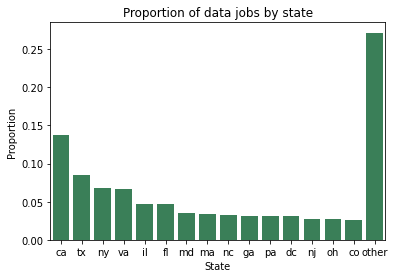

In [47]:
statetable = df['state'].value_counts().rename_axis('state').reset_index(name='frequency')
other_count = statetable.iloc[15:, 1].sum()
statetable.loc[len(statetable['state']),:] = ['other', other_count]
statetable = statetable.drop(list(range(15, 60)))

statetable['proportion'] = statetable['frequency'] / (statetable['frequency'].sum())
statetable['percent'] = statetable['proportion'].mul(100).round(1).astype(str) + '%'

ax1 = sns.barplot(data=statetable, x='state', y='proportion', color="seagreen")
ax1.set(xlabel='State', ylabel='Proportion', title='Proportion of data jobs by state')

# proportion for first 15 states 
statetable.iloc[:15,2].sum().round(3)*100
statetable

,industry,frequency,proportion,percent
0,computer-or-internet,529.0,0.210422,21.0%
1,accounting-or-finance,376.0,0.149562,15.0%
2,administrative,245.0,0.097454,9.7%
3,manufacturing-or-mechanical,185.0,0.073588,7.4%
4,banking-or-loans,159.0,0.063246,6.3%
5,engineering-or-architecture,157.0,0.062450,6.2%
6,upper-management-or-consulting,109.0,0.043357,4.3%
7,marketing-or-advertising-or-pr,76.0,0.030231,3.0%
8,accounting/finance,71.0,0.028242,2.8%
9,government-or-military,70.0,0.027844,2.8%


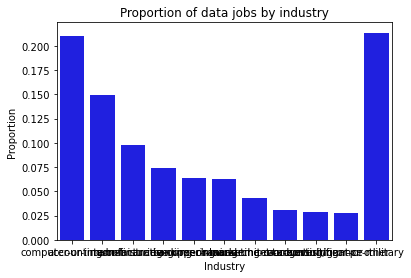

In [48]:
industrytable = df['category'].value_counts().rename_axis('industry').reset_index(name='frequency')
other_count = industrytable.iloc[10:, 1].sum()
industrytable.loc[len(industrytable['industry']),:] = ['other', other_count]
industrytable = industrytable.drop(list(range(10, 41)))

industrytable['proportion'] = industrytable['frequency'] / (industrytable['frequency'].sum())
industrytable['percent'] = industrytable['proportion'].mul(100).round(1).astype(str) + '%'

ax2 = sns.barplot(data=industrytable, x='industry', y='proportion', color="blue")
ax2.set(xlabel='Industry', ylabel='Proportion', title='Proportion of data jobs by industry')

industrytable

## Bivariate analysis

check for relationships between seniority and variables of interest:
- since all categorical data, most appropriate method would be using chi-square test
- but also consider effects of logistic regression

results:
- unexpected that have more senior level workers for both having and not having a particular skill/tool
  - perhaps some skills are more universal, whereas some skills not required for management focused roles?
  - exception/opposite or null effect: analysis, python, r, excel

  - significant (p-value<0.05): analysis, visualization, excel, also sql nearly significant 
  - not sure for what reason these skills/tools relation with seniority 
  - suggests that basics are important (analysis, excel, sql)
  - also some skills are specialized? (visualization)

seniority         0    1
transformation          
0               766  912
1               361  475
Chi-sq value= 1.2759826897053277, p-value= 0.25864732455600536, Degrees of freedom= 1
seniority    0    1
technical          
0          762  912
1          365  475
Chi-sq value= 0.884760709269525, p-value= 0.34690106644001095, Degrees of freedom= 1
seniority     0     1
analysis             
0           104    82
1          1023  1305
Chi-sq value= 9.501126639428461, p-value= 0.0020534577317980105, Degrees of freedom= 1
seniority        0     1
visualization           
0              915  1048
1              212   339
Chi-sq value= 11.190564366653609, p-value= 0.0008221433525602478, Degrees of freedom= 1
seniority    0     1
python              
0          956  1190
1          171   197
Chi-sq value= 0.393531450766397, p-value= 0.5304489379004338, Degrees of freedom= 1
seniority     0     1
r                    
0          1047  1301
1            80    86
Chi-sq value= 0.67404421438375

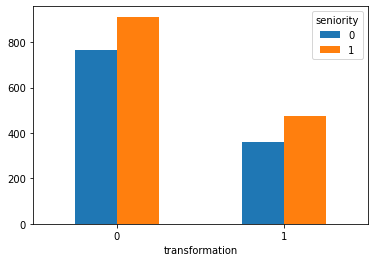

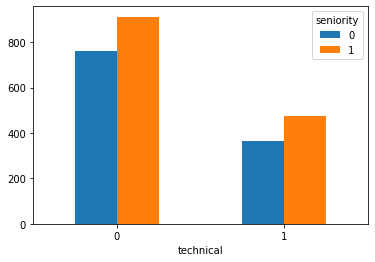

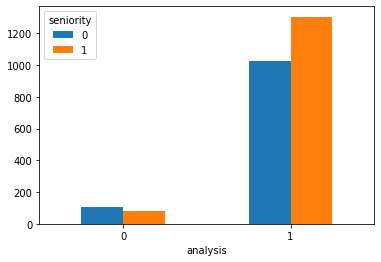

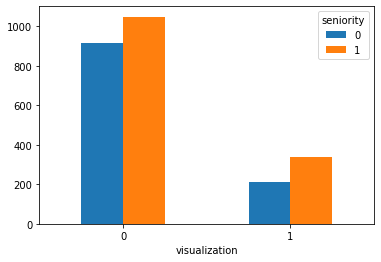

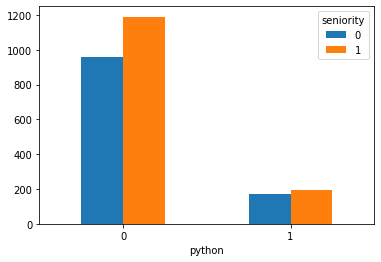

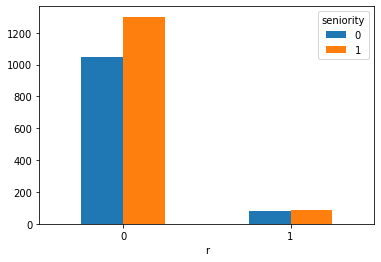

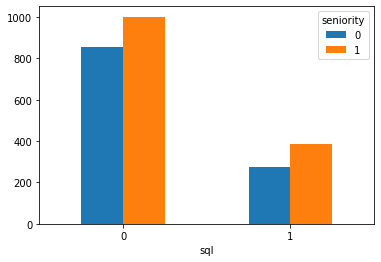

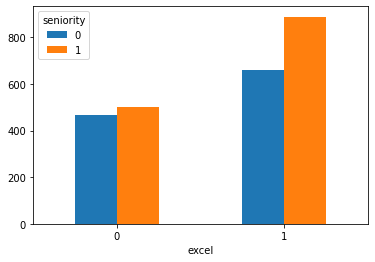

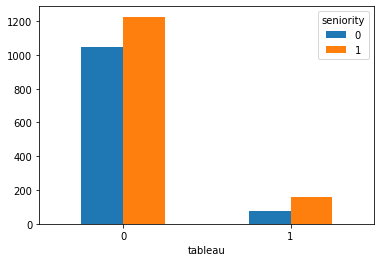

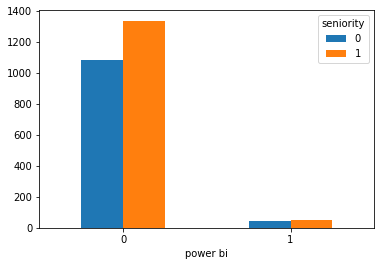

In [75]:
for col in skills:
  crosstab = pd.crosstab(df[col], df['seniority'])
  print(crosstab)
  crosstab.plot.bar(rot=0)
  chi2, p, dof, expected = stats.chi2_contingency(crosstab)
  print(f"Chi-sq value= {chi2}, p-value= {p}, Degrees of freedom= {dof}")

for col in tools:
  crosstab = pd.crosstab(df[col], df['seniority'])
  print(crosstab)
  crosstab.plot.bar(rot=0)
  chi2, p, dof, expected = stats.chi2_contingency(crosstab)
  print(f"Chi-sq value= {chi2}, p-value= {p}, Degrees of freedom= {dof}")


check for balance of sample across years

In [50]:
print('2019 data:', len(df[(df['y20']==0) & (df['y21']==0)]), '\n2020 data:', df['y20'].sum(), '\n2021 data:', df['y21'].sum())

df.info()

2019 data: 969 
2020 data: 772 
2021 data: 773
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2514 entries, 5 to 29907
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        2514 non-null   object
 1   category         2514 non-null   object
 2   company_name     2514 non-null   object
 3   city             2470 non-null   object
 4   state            2337 non-null   object
 5   country          2514 non-null   object
 6   job_description  2514 non-null   object
 7   y20              2514 non-null   int64 
 8   y21              2514 non-null   int64 
 9   seniority        2514 non-null   int64 
 10  transformation   2514 non-null   int64 
 11  technical        2514 non-null   int64 
 12  analysis         2514 non-null   int64 
 13  visualization    2514 non-null   int64 
 14  python           2514 non-null   int64 
 15  r                2514 non-null   int64 
 16  sql              2514 non-null

data changelog:
1. drop columns with mostly or all null values
2. drop un-useful columns

Notes:
- datasets had different number of columns (2019: 29, 2020: 76, 2021: 54)
- clean dataset separately to double check data types and non-nulls
  - also, indicator variables for years planned for later
  - re-order rows for each dataset to concat later
- only filtered for exception to data jobs when they appeared more than twice, sizeable amount of noise in sample remains
- restricted number of categories for descriptive stats for states and industry
- not sure how to identify outliers for categorical data
- not sure how to validate or correct data for data with many categories (job category definitely has mislabels, also 'risk manager' for seniority)
  - also; mistype, misspell


lessons:
- pre-optimizing is bad
- Colab is (*very*) limited
- analysis only as good as data source
- data cleaning/transformation/loading is 90% of the work
- pipe style code 

next time:
- GLM, ANOVA, factorial design